In [70]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from feat_desc import *
import cv2
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000,formatter=dict(float=lambda x: "%.3g" % x))
from corner_detector import *
from anms import *
from feat_match import *
from ransac_est_homography import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


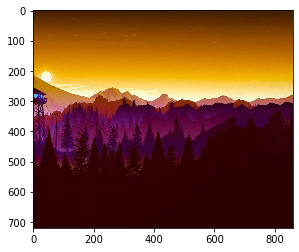

In [71]:
# img1=cv2.imread('small-middle.jpg')
# img1=cv2.imread('mountain1.jpg')
img1 = cv2.imread('firewatch-right.jpg')
# img1=cv2.imread('case1.png')
# img1=cv2.imread('rot-middle.jpg')
plt.imshow(img1)
plt.show()

In [72]:
img1.shape

(720, 860, 3)

In [73]:
import numpy as np

def interp2(v, xq, yq):

	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

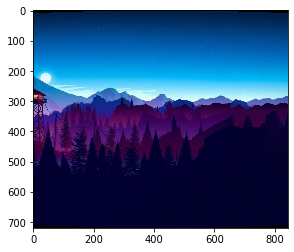

Lossy conversion from float64 to uint8. Range [0.0, 255.00000000000006]. Convert image to uint8 prior to saving to suppress this warning.


In [75]:
f = 3442.0/2
xc = img1.shape[1]/2
yc = img1.shape[0]/2
edgecenters = np.asarray([[0,img1.shape[0]/2],[img1.shape[1]/2,0],[img1.shape[1],img1.shape[0]/2],[img1.shape[1]/2,img1.shape[0]],[0,0],[0,img1.shape[0]],[img1.shape[1],0],[img1.shape[1],img1.shape[0]]])
x_ecs = edgecenters[:,0]
y_ecs = edgecenters[:,1]
x_ecsT = f*np.arctan((x_ecs-xc)/f) + xc
y_ecsT = (y_ecs-yc)*f/(np.sqrt((x_ecs-xc)**2 + f**2))+yc
xmax = int(np.max(x_ecsT))
xmin = int(np.min(x_ecsT))
ymax = int(np.max(y_ecsT))
ymin = int(np.min(y_ecsT))
sizex = int(xmax-xmin)
sizey = int(ymax-ymin)
xT_r = np.array(range(sizex))
xT_r = xT_r+xmin
yT_r = np.array(range(sizey))
yT_r = yT_r+ymin
# xT_r = np.array(range(sizex))
# yT_r = np.array(range(sizey))
XT,YT = np.meshgrid(xT_r,yT_r)
X_og = np.tan((XT-xc)/f)*f + xc
Y_og = (YT - yc)*np.sqrt((X_og-xc)**2 + f**2)/f + yc
im1BT = interp2(img1[:,:,0],X_og,Y_og)
im1GT = interp2(img1[:,:,1],X_og,Y_og)
im1RT = interp2(img1[:,:,2],X_og,Y_og)
outliersX1 = np.argwhere(X_og>img1.shape[1])
outliersX2 = np.argwhere(X_og<0)
outliersY1 = np.argwhere(Y_og>img1.shape[0])
outliersY2 = np.argwhere(Y_og<0)
outliers = np.vstack([outliersX1,outliersX2,outliersY1,outliersY2])
im1BT[outliers[:,0],outliers[:,1]]=0
im1GT[outliers[:,0],outliers[:,1]]=0
im1RT[outliers[:,0],outliers[:,1]]=0
img1T = np.zeros([sizey,sizex,3])
img1T[:,:,2] = im1BT
img1T[:,:,1] = im1GT
img1T[:,:,0] = im1RT
plt.imshow(img1T.astype(int))
plt.show()
from skimage.io import imsave
imsave('cylin3.jpeg',img1T)

In [39]:
print(x_ecsT)
print(y_ecsT)
print(x_ecs)
print(y_ecs)
np.arctan(edgecenters[:,0]-xc)
print(f/(np.sqrt((x_ecs-xc)**2 + f**2)))


[3.08 480 957 480 3.08 3.08 957 957]
[360 0 360 720 3.45 717 3.45 717]
[0 480 960 480 0 0 960 960]
[360 0 360 720 0 720 0 720]
[0.99 1 0.99 1 0.99 0.99 0.99 0.99]
